In [1]:
import os

subj = "Subj1"
exp = "exp_iv"
print_obj = 29
os.makedirs(f"{subj}/{exp}", exist_ok = True)

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import collections
warnings.filterwarnings("ignore")

import mne
import tqdm
import scipy
import numpy
import pandas
import scipy.stats
import gtda.curves
import tqdm.contrib
import gtda.plotting
import gtda.homology
import gtda.diagrams
import gtda.time_series
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
import matplotlib.pyplot as plt
import matplotlib.patches as ptchs
pandas.options.display.float_format = '{:,.2f}'.format

#### IV

In [3]:
def calc_IV(feature: numpy.ndarray, target: numpy.ndarray, bins: int = 10) -> float:
    if len(numpy.unique(feature)) > 10:
        feature = pandas.qcut(feature, bins, duplicates = 'drop')
    df = pandas.DataFrame({ 'x': feature, 'y': target })
    df = df.groupby("x", as_index = False).agg({ "y": [ "count", "sum" ] })
    df.columns = [ 'Cutoff', 'N', 'Events' ]

    # Calculate % of events in each group.
    df['% of Events'] = numpy.maximum(df['Events'], 0.5) / df['Events'].sum()

    # Calculate the non events in each group.
    df['Non-Events'] = df['N'] - df['Events']
    # Calculate % of non events in each group.
    df['% of Non-Events'] = numpy.maximum(df['Non-Events'], 0.5) / df['Non-Events'].sum()

    # Calculate WOE by taking natural log of division of % of non-events and % of events
    df['WoE'] = numpy.log(df['% of Events'] / df['% of Non-Events'])
    df['IV'] = df['WoE'] * (df['% of Events'] - df['% of Non-Events'])

    return df['IV'].sum()

In [80]:
# Calculation of IV and WoE for given DataFrame of features and given clustering labels 
def calc_IV_clust(features: pandas.DataFrame, labels: numpy.ndarray, bins: int = 10) -> pandas.DataFrame:
    IV = [ ]
    for feature_name in tqdm.tqdm(features.columns):
        IVs = [ ]
        feature = features[feature_name].to_numpy()
        for cluster in numpy.unique(labels):
            target = (labels == cluster).astype(int)
            IVs.append(calc_IV(feature, target, bins))
        IV.append({ 'Feature': feature_name, 'IV': numpy.mean(IVs), 'IVs': IVs })
    return pandas.DataFrame(IV)

### Features

In [5]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
print(edges_true)

import SDA.stageprocess
labels_true = SDA.stageprocess.form_stage_bands(edges_true)[1]
print(labels_true)

[   0   39  282  492  560  682  784  857  976 1046]
[0. 0. 0. ... 8. 8. 8.]


Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


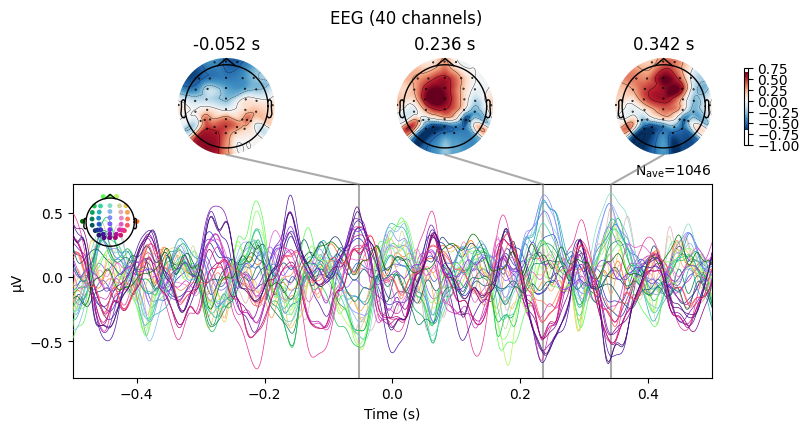

In [23]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
g = epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)
n_features = data.shape[1]

#### Settings

In [91]:
FILTERING_PERCENTILE = 15
IV_THRESHOLD = 0.8

STRIDE = 3
MAX_TIME_DELAY = 20
MAX_DIMENSION = 20
HOMOLOGY_DIMENSIONS = [ 1, 2 ]
READ_EMBEDDER_PARAMS_FROM_DISK = True

DISSIM_DIMENSION = 64
DISSIM_TIME_DELAY = 1
DISSIM_STRIDE = 16
DISSIM_HOMOLOGY_DIMENSIONS = [ 1, 2, 3, 4, 5 ]

OVERALL_DIMENSION = 5
OVERALL_TIME_DELAY = 11
OVERALL_STRIDE = 3
OVERALL_HOMOLOGY_DIMENSIONS = [ 1, 2, 3 ]

#### Utilities

(9, 64)


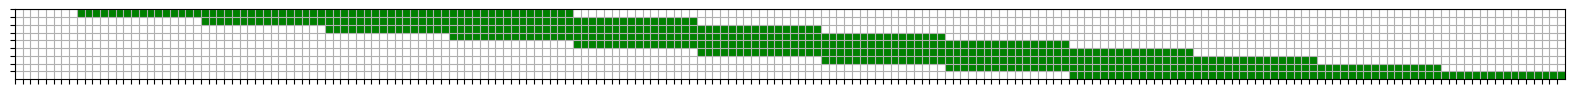

In [8]:
def draw(dimension, time_delay, stride, res = 200):
    data = numpy.arange(res)
    embedder = gtda.time_series.SingleTakensEmbedding(parameters_type = 'fixed', time_delay = time_delay, dimension = dimension, stride = stride)
    points = embedder.fit_transform(data)
    print(points.shape)
    fig, ax = plt.subplots(1, 1, figsize = (20, 100))
    ax.grid()
    ax.set_aspect('equal')
    ax.set_xlim(0, res)
    ax.set_ylim(points.shape[0], 0)
    ax.set_xticks(data)
    ax.set_yticks(numpy.arange(points.shape[0]))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    for i in range(points.shape[0]):
        for item in points[i]:
            rect = ptchs.Rectangle((item, i), 1, 1, facecolor = 'green')
            ax.add_patch(rect)

draw(DISSIM_DIMENSION, DISSIM_TIME_DELAY, DISSIM_STRIDE)

In [18]:
class FeatureCalculator:
    def determine_filtering_epsilon(self, diagram):
        life = (diagram[:, :, 1] - diagram[:, :, 0]).flatten()
        life = life[life != 0]
        return numpy.percentile(life, FILTERING_PERCENTILE)
    
    def apply_filtering(self, diagrams):
        eps = self.determine_filtering_epsilon(diagrams)
        self.filtering = gtda.diagrams.Filtering(epsilon = eps)
        return self.filtering.fit_transform(diagrams)


    def calc_stats(self, data: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        assert len(data.shape) == 1
        if data.shape == (0,): data = numpy.array([ 0 ])
        stats = numpy.array([
            numpy.max(data), numpy.mean(data), numpy.std(data), numpy.sum(data), numpy.linalg.norm(data),
            numpy.percentile(data, 25), numpy.median(data), numpy.percentile(data, 75), numpy.percentile(data, 90),
            scipy.stats.kurtosis(data), scipy.stats.skew(data)
        ])
        names = [ "max", "mean", "std", "sum", "norm", "percentile-25", "median", "percentile-75", "percentile-90", "kurtosis", "skew" ]
        return pandas.DataFrame([ numpy.nan_to_num(stats) ], columns = [ f"{prefix} {name}" for name in names ])
    

    def calc_betti_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.betti_curve = gtda.diagrams.BettiCurve()
        self.betti_derivative = gtda.curves.Derivative()

        betti_curves = self.betti_curve.fit_transform(diagrams)
        betti_curves = self.betti_derivative.fit_transform(betti_curves)

        features = [ ]
        for curves in tqdm.tqdm(betti_curves):
            features.append([ ])
            for dim, curve in zip(self.betti_curve.homology_dimensions_, curves):
                features[-1].append(self.calc_stats(curve, prefix = f'{prefix} betti-{dim}'))
            features[-1] = pandas.concat(features[-1], axis = 1)
        return pandas.concat(features, axis = 0)
    
    def calc_entropy_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.entropy = gtda.diagrams.PersistenceEntropy(normalize = True, nan_fill_value = 0)
        features = self.entropy.fit_transform(diagrams)
        names = [ f'{prefix} entropy-{dim}' for dim in self.entropy.homology_dimensions_ ]
        return pandas.DataFrame(features, columns = names)
    
    def calc_number_of_points_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        self.number_of_points = gtda.diagrams.NumberOfPoints()
        features = self.number_of_points.fit_transform(diagrams)
        names = [ f'{prefix} numberofpoints-{dim}' for dim in self.number_of_points.homology_dimensions_ ]
        return pandas.DataFrame(features, columns = names)
    
    def calc_amplitude_features(self, diagrams: numpy.ndarray, prefix: str = "", metric: str = None) -> pandas.DataFrame:
        if metric is None:
            features = [ ]
            self.amplitudes = [ ]
            for metric in tqdm.tqdm([ 'bottleneck', 'wasserstein', 'betti', 'landscape', 'silhouette' ]):
                features.append(self.calc_amplitude_features(diagrams, prefix, metric))
            return pandas.concat(features, axis = 1)
        else:
            amplitude = gtda.diagrams.Amplitude(metric = metric)
            self.amplitudes.append(amplitude)
            features = amplitude.fit_transform(diagrams)
            return pandas.concat([
                pandas.DataFrame(features, columns = [ f'{prefix} {metric}-amplitude-{dim}' for dim in amplitude.homology_dimensions_ ]),
                pandas.DataFrame(numpy.linalg.norm(features, axis = 1).reshape(-1, 1), columns = [ f'{prefix} {metric}-amplitude-norm' ])
            ], axis = 1)
    
    def calc_lifetime_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        if len(diagrams.shape) == 3:
            features = [ ]
            for diag in tqdm.tqdm(diagrams):
                features.append(self.calc_lifetime_features(diag, prefix))
            return pandas.concat(features, axis = 0)

        birth, death, dim = diagrams[:, 0], diagrams[:, 1], diagrams[:, 2]
        life = death - birth
        
        eps = self.filtering.epsilon
        birth, death, dim = birth[life >= eps], death[life >= eps], dim[life >= eps]
        bd2 = (birth + death) / 2.0
        life = death - birth

        bd2_features = [ self.calc_stats(bd2, f'{prefix} bd2-all') ]
        life_features = [ self.calc_stats(life, f'{prefix} life-all') ]
        for d in numpy.unique(diagrams[:, 2]).astype(int):
            bd2_features.append(self.calc_stats(bd2[dim == d], f'{prefix} bd2-{d}'))
            life_features.append(self.calc_stats(life[dim == d], f'{prefix} life-{d}'))
        return pandas.concat([ *life_features, *bd2_features ], axis = 1)
        

    def calc_features(self, diagrams: numpy.ndarray, prefix: str = "") -> pandas.DataFrame:
        diagrams = self.apply_filtering(diagrams)
        return pandas.concat([
           self.calc_betti_features           (diagrams, prefix).reset_index(drop = True),
           self.calc_entropy_features         (diagrams, prefix).reset_index(drop = True),
           self.calc_number_of_points_features(diagrams, prefix).reset_index(drop = True),
           self.calc_amplitude_features       (diagrams, prefix).reset_index(drop = True),
           self.calc_lifetime_features        (diagrams, prefix).reset_index(drop = True)
        ], axis = 1)


    def pca(self, features: numpy.ndarray, scale = False, n_comp = 0.7, var_limit = None, random_state = 42) -> numpy.ndarray:
        if scale:
            features = sklearn.preprocessing.StandardScaler().fit_transform(features)

        if var_limit is not None:
            pca = sklearn.decomposition.PCA(random_state = random_state).fit(features)
            n_comp = (pca.explained_variance_ratio_ >= var_limit).sum()

        pca = sklearn.decomposition.PCA(n_components = n_comp, random_state = random_state)
        features = pca.fit_transform(features)

        print('Components:', n_comp)
        print('Explained variance:', round(pca.explained_variance_ratio_.sum(), 2))
        print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
        return features

#### Takens Embeddings & VietorisRipsPersistence

##### TakensEmbedding

In [10]:
if READ_EMBEDDER_PARAMS_FROM_DISK:
    embedders_params = [ ]
    for params_data in numpy.load(f"{subj}/{exp}/embedders_params.npy"):
        embedders_params.append(list(map(tuple, params_data)))
else:
    searcher = gtda.time_series.SingleTakensEmbedding(parameters_type = 'search', time_delay = MAX_TIME_DELAY, dimension = MAX_DIMENSION, stride = STRIDE, n_jobs = -1)
    embedders_params = [ [ ] for _ in range(data.shape[1]) ]
    for i, j in tqdm.contrib.itertools.product(range(data.shape[0]), range(data.shape[1])):
        searcher.fit(data[i, j, :])
        embedders_params[j].append((searcher.dimension_, searcher.time_delay_))
    numpy.save(f"{subj}/{exp}/embedders_params.npy", embedders_params)

print(len(embedders_params))
print(len(embedders_params[0]))

40
1046


In [11]:
embedders = [ ]
for i in range(len(embedders_params)):
    (dimension, time_delay), _ = collections.Counter(embedders_params[i]).most_common(1)[0]
    attractor = gtda.time_series.SingleTakensEmbedding(parameters_type = 'fixed', time_delay = int(time_delay), dimension = int(dimension), stride = STRIDE, n_jobs = -1)
    embedders.append(attractor)
    
print(embedders)
print(len(embedders))

[SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=8), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=16), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=7), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=8), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=11), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=16), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=7), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=10), SingleTakensEmbedding(n_jobs=-1, parameters_type='fixed', stride=3,
                      time_delay=16), SingleTakensEmbedding(n_jobs=-1, parameters_type=

In [12]:
point_clouds = [ ]
for i, j in tqdm.contrib.itertools.product(range(data.shape[0]), range(data.shape[1])):
    point_clouds.append(embedders[j].fit_transform(data[i, j, :]))

print(len(point_clouds))
print(point_clouds[0].shape, point_clouds[1].shape)
print(point_clouds[40].shape, point_clouds[41].shape)

  0%|          | 0/41840 [00:00<?, ?it/s]

41840
(157, 5) (146, 5)
(157, 5) (146, 5)


In [13]:
point_clouds_plot = gtda.plotting.plot_point_cloud(point_clouds[print_obj])
display(point_clouds_plot)
point_clouds_plot.write_image(file = f"{subj}/{exp}/point_cloud.svg", format = "svg")

##### VietorisRipsPersistence

In [14]:
persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = HOMOLOGY_DIMENSIONS, n_jobs = -1)
diagrams = persistence.fit_transform(point_clouds)
print(diagrams.shape)

(41840, 195, 3)


In [15]:
diagrams_plot = gtda.plotting.plot_diagram(diagrams[print_obj])
display(diagrams_plot)
diagrams_plot.write_image(file = f"{subj}/{exp}/diagram.svg", format = "svg")

##### FeatureCalculator

In [19]:
channel_features_raw = FeatureCalculator().calc_features(diagrams)
channel_features_raw

100%|██████████| 41840/41840 [04:12<00:00, 165.90it/s]


,betti-1 max,betti-1 mean,betti-1 std,betti-1 sum,betti-1 norm,betti-1 percentile-25,betti-1 median,betti-1 percentile-75,betti-1 percentile-90,betti-1 kurtosis,...,bd2-2 mean,bd2-2 std,bd2-2 sum,bd2-2 norm,bd2-2 percentile-25,bd2-2 median,bd2-2 percentile-75,bd2-2 percentile-90,bd2-2 kurtosis,bd2-2 skew
0,18.00,0.00,3.10,0.00,30.82,0.00,0.00,0.00,0.00,19.58,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.79,0.66
1,14.00,0.00,2.07,0.00,20.64,0.00,0.00,0.00,0.00,27.49,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.15,-1.44
2,10.00,0.00,1.59,0.00,15.81,0.00,0.00,0.00,0.00,21.90,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.86,-0.70
3,16.00,0.00,2.32,0.00,23.07,0.00,0.00,0.00,0.00,33.92,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,1.00
4,7.00,0.00,1.31,0.00,13.04,0.00,0.00,0.00,0.00,29.19,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.34,-0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41835,12.00,0.00,2.31,0.00,22.93,0.00,0.00,0.00,0.00,25.86,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.68,0.65
41836,12.00,0.00,1.49,0.00,14.83,0.00,0.00,0.00,0.00,41.98,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.11,-0.20
41837,10.00,0.00,1.36,0.00,13.56,0.00,0.00,0.00,0.00,31.82,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.81,0.15
41838,18.00,0.00,2.43,0.00,24.21,0.00,0.00,0.00,0.00,42.05,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.20,0.35


In [45]:
columns = [ f"feature-{i}{feature_name}" for i in range(n_features) for feature_name in channel_features_raw ]
channel_features = pandas.concat([ channel_features_raw.iloc[i::n_features, :].reset_index(drop = True) for i in range(n_features) ], axis = 1)
channel_features.columns = columns
channel_features

,feature-0 betti-1 max,feature-0 betti-1 mean,feature-0 betti-1 std,feature-0 betti-1 sum,feature-0 betti-1 norm,feature-0 betti-1 percentile-25,feature-0 betti-1 median,feature-0 betti-1 percentile-75,feature-0 betti-1 percentile-90,feature-0 betti-1 kurtosis,...,feature-39 bd2-2 mean,feature-39 bd2-2 std,feature-39 bd2-2 sum,feature-39 bd2-2 norm,feature-39 bd2-2 percentile-25,feature-39 bd2-2 median,feature-39 bd2-2 percentile-75,feature-39 bd2-2 percentile-90,feature-39 bd2-2 kurtosis,feature-39 bd2-2 skew
0,18.00,0.00,3.10,0.00,30.82,0.00,0.00,0.00,0.00,19.58,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.35,-0.17
1,25.00,0.00,3.68,0.00,36.66,0.00,0.00,0.00,0.00,34.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.44,1.42
2,15.00,0.00,2.60,0.00,25.85,0.00,0.00,0.00,0.00,22.20,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.66,2.07
3,7.00,0.00,1.52,0.00,15.10,0.00,0.00,0.00,0.00,18.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.35,0.51
4,6.00,0.00,1.46,0.00,14.56,0.00,0.00,0.00,0.00,19.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.43,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,13.00,0.00,1.65,0.00,16.37,0.00,0.00,0.00,0.00,38.08,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.03,-0.18
1042,6.00,0.00,0.95,0.00,9.49,0.00,0.00,0.00,0.00,18.19,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.68,1.13
1043,11.00,0.00,1.92,0.00,19.08,0.00,0.00,0.00,0.00,21.42,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85,1.42
1044,5.00,0.00,0.86,0.00,8.60,0.00,0.00,0.00,0.00,15.91,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.42,0.22


In [48]:
channel_features_pca = FeatureCalculator().pca(channel_features, scale = True, n_comp = 32)
print(channel_features_pca.shape)
pandas.DataFrame(channel_features_pca).describe()

Components: 32
Explained variance: 0.54
[0.201, 0.077, 0.032, 0.024, 0.023, 0.016, 0.014, 0.011, 0.01, 0.01, 0.009, 0.008, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]
(1046, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,"1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00",...,"1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00"
mean,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00
std,27.72,17.22,11.12,9.67,9.37,7.89,7.28,6.54,6.27,6.07,...,4.42,4.35,4.32,4.23,4.13,4.07,4.06,4.05,3.99,3.97
min,-69.14,-47.12,-35.24,-36.97,-35.98,-33.93,-29.31,-28.81,-22.92,-28.43,...,-15.37,-19.44,-18.47,-12.74,-16.64,-13.23,-16.90,-18.22,-12.85,-13.57
25%,-18.02,-8.93,-7.45,-6.44,-5.65,-4.86,-4.55,-4.16,-4.08,-3.53,...,-2.67,-2.80,-2.50,-2.54,-2.51,-2.49,-2.48,-2.34,-2.37,-2.34
50%,-1.65,2.31,-0.75,-0.55,0.64,0.33,-0.22,-0.19,0.34,0.29,...,-0.15,0.04,-0.09,0.09,-0.05,0.06,-0.05,-0.01,-0.02,-0.06
75%,16.24,11.46,6.88,6.37,6.33,5.14,4.32,3.49,3.75,3.89,...,2.57,2.70,2.73,2.52,2.54,2.44,2.59,2.46,2.46,2.24
max,135.39,48.80,38.93,37.51,36.17,50.14,43.71,29.18,37.77,30.30,...,21.39,20.98,24.29,23.97,18.85,18.73,23.58,20.17,13.49,22.34


#### PearsonDissimilarity

##### TakensEmbedding & PearsonDissimilarity

In [51]:
dissim_matrixes = [ ]
for epoch in tqdm.tqdm(data):
    dissim_embedding = gtda.time_series.TakensEmbedding(dimension = DISSIM_DIMENSION, time_delay = DISSIM_TIME_DELAY, stride = DISSIM_STRIDE, flatten = False)
    dissim_point_clouds = dissim_embedding.fit_transform(epoch).transpose(1, 2, 0)
    
    dissim = gtda.time_series.PearsonDissimilarity()
    dissim_matrix = dissim.fit_transform(dissim_point_clouds)
    dissim_matrixes.append(dissim_matrix)

    epoch_ts = numpy.expand_dims(epoch.transpose(1, 0), 0)
    dissim_matrix = dissim.fit_transform(epoch_ts)
    dissim_matrixes.append(dissim_matrix)

dissim_matrixes = numpy.concatenate(dissim_matrixes, axis = 0)
print(dissim_matrixes.shape)

100%|██████████| 1046/1046 [00:02<00:00, 450.72it/s]


(30334, 40, 40)


In [52]:
dissim_matrixes_plot = gtda.plotting.plot_heatmap(dissim_matrixes[print_obj], colorscale = 'YlOrRd')
display(dissim_matrixes_plot)
dissim_matrixes_plot.write_image(file = f"{subj}/{exp}/dissim_matrix.svg", format = "svg")

##### VietorisRipsPersistence

In [53]:
dissim_persistence = gtda.homology.VietorisRipsPersistence(metric = "precomputed", homology_dimensions = DISSIM_HOMOLOGY_DIMENSIONS, n_jobs = -1)
dissim_diagrams = dissim_persistence.fit_transform(dissim_matrixes)
print(dissim_diagrams.shape)

(30334, 51, 3)


In [54]:
dissim_diagrams_plot = gtda.plotting.plot_diagram(dissim_diagrams[print_obj])
display(dissim_diagrams_plot)
dissim_diagrams_plot.write_image(file = f"{subj}/{exp}/dissim_diagram.svg", format = "svg")

##### FeatureCalculator

In [55]:
dissim_features_raw = FeatureCalculator().calc_features(dissim_diagrams)
dissim_features_raw

100%|██████████| 30334/30334 [06:13<00:00, 81.13it/s]


(30334, 227)


In [63]:
n_dissim = dissim_features_raw.shape[0] // data.shape[0]
columns = [ f"dissim-{i}{feature_name}" for i in range(n_dissim) for feature_name in dissim_features_raw ]
dissim_features = pandas.concat([ dissim_features_raw.iloc[i::n_dissim, :].reset_index(drop = True) for i in range(n_dissim) ], axis = 1)
dissim_features.columns = columns
dissim_features

,dissim-0 betti-1 max,dissim-0 betti-1 mean,dissim-0 betti-1 std,dissim-0 betti-1 sum,dissim-0 betti-1 norm,dissim-0 betti-1 percentile-25,dissim-0 betti-1 median,dissim-0 betti-1 percentile-75,dissim-0 betti-1 percentile-90,dissim-0 betti-1 kurtosis,...,dissim-28 bd2-5 mean,dissim-28 bd2-5 std,dissim-28 bd2-5 sum,dissim-28 bd2-5 norm,dissim-28 bd2-5 percentile-25,dissim-28 bd2-5 median,dissim-28 bd2-5 percentile-75,dissim-28 bd2-5 percentile-90,dissim-28 bd2-5 kurtosis,dissim-28 bd2-5 skew
0,2.00,0.00,0.47,0.00,4.69,0.00,0.00,0.00,0.00,6.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2.00,0.00,0.28,0.00,2.83,0.00,0.00,0.00,0.00,27.94,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.00,0.00,0.38,0.00,3.74,0.00,0.00,0.00,0.00,4.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2.00,0.00,0.32,0.00,3.16,0.00,0.00,0.00,0.00,18.78,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,0.00,0.28,0.00,2.83,0.00,0.00,0.00,0.00,9.38,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1.00,0.00,0.14,0.00,1.41,0.00,0.00,0.00,0.00,46.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1042,1.00,0.00,0.25,0.00,2.45,0.00,0.00,0.00,0.00,13.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1043,1.00,0.00,0.28,0.00,2.83,0.00,0.00,0.00,0.00,9.38,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1044,1.00,0.00,0.47,0.00,4.69,0.00,0.00,0.00,0.20,3.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [65]:
dissim_features_pca = FeatureCalculator().pca(dissim_features, scale = True, n_comp = 32)
print(dissim_features_pca.shape)
pandas.DataFrame(dissim_features_pca).describe()

Components: 32
Explained variance: 0.35
[0.049, 0.022, 0.019, 0.018, 0.015, 0.014, 0.012, 0.012, 0.011, 0.011, 0.01, 0.009, 0.009, 0.009, 0.009, 0.008, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006]
(1046, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,"1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00",...,"1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00"
mean,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,...,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00
std,16.82,11.20,10.44,10.06,9.39,8.80,8.45,8.14,8.02,7.81,...,6.26,6.21,6.18,6.14,6.03,5.98,5.93,5.85,5.80,5.74
min,-35.15,-29.89,-41.33,-40.79,-33.53,-29.77,-32.76,-25.63,-33.16,-23.50,...,-23.07,-28.14,-23.87,-22.70,-27.26,-29.53,-23.20,-18.44,-26.91,-17.83
25%,-12.43,-7.15,-6.57,-6.67,-5.64,-5.24,-5.46,-4.72,-4.71,-4.96,...,-3.95,-3.44,-3.64,-3.55,-3.64,-3.48,-3.59,-3.81,-3.53,-3.50
50%,-1.81,-0.48,-0.51,-0.43,-0.03,0.00,-0.04,-0.04,-0.10,-0.11,...,-0.16,-0.26,0.05,0.07,-0.07,0.05,-0.13,-0.15,-0.21,0.05
75%,9.70,6.86,6.42,6.39,5.92,4.99,5.36,4.83,4.75,4.87,...,3.53,3.45,3.69,3.57,3.63,3.55,3.15,3.40,3.25,3.70
max,76.29,38.83,58.29,42.07,36.32,31.81,33.33,28.31,38.74,43.43,...,29.11,46.54,25.12,27.64,28.87,30.48,29.74,28.84,29.45,20.38


#### Overall

##### TakensEmbedding

In [66]:
overall_embedding = gtda.time_series.TakensEmbedding(dimension = OVERALL_DIMENSION, time_delay = OVERALL_TIME_DELAY, stride = OVERALL_STRIDE, flatten = True)
overall_point_clouds = overall_embedding.fit_transform(data)
print(overall_point_clouds.shape)

(1046, 153, 200)


In [67]:
overall_point_clouds_plot = gtda.plotting.plot_point_cloud(overall_point_clouds[print_obj])
display(overall_point_clouds_plot)
overall_point_clouds_plot.write_image(file = f"{subj}/{exp}/overall_point_cloud.svg", format = "svg")

##### VietorisRipsPersistence

In [68]:
overall_persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = OVERALL_HOMOLOGY_DIMENSIONS, n_jobs = -1)
overall_diagrams = overall_persistence.fit_transform(overall_point_clouds)
print(overall_diagrams.shape)

(1046, 205, 3)


In [69]:
overall_diagrams_plot = gtda.plotting.plot_diagram(overall_diagrams[print_obj])
display(overall_diagrams_plot)
overall_diagrams_plot.write_image(file = f"{subj}/{exp}/overall_diagram.svg", format = "svg")

##### FeatureCalculator

In [70]:
overall_features = FeatureCalculator().calc_features(overall_diagrams)
print(overall_features.shape)

100%|██████████| 1046/1046 [00:08<00:00, 128.67it/s]


(1046, 147)


In [71]:
overall_features_pca = FeatureCalculator().pca(overall_features, scale = True, n_comp = 32)
print(overall_features_pca.shape)
pandas.DataFrame(overall_features_pca).describe()

Components: 32
Explained variance: 0.96
[0.327, 0.142, 0.072, 0.054, 0.053, 0.039, 0.026, 0.022, 0.02, 0.019, 0.016, 0.016, 0.015, 0.015, 0.013, 0.01, 0.01, 0.009, 0.009, 0.008, 0.008, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006, 0.005, 0.004, 0.004, 0.003]
(1046, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,"1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00",...,"1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00","1,046.00"
mean,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,6.67,4.40,3.13,2.72,2.67,2.29,1.87,1.73,1.65,1.59,...,0.96,0.95,0.92,0.91,0.89,0.87,0.81,0.74,0.69,0.66
min,-20.32,-12.43,-13.18,-7.92,-13.03,-12.21,-8.60,-6.84,-9.46,-4.88,...,-3.26,-2.91,-2.78,-3.57,-2.94,-3.15,-2.37,-2.29,-3.28,-2.64
25%,-4.88,-2.98,-1.76,-1.58,-1.57,-1.37,-1.15,-1.19,-0.90,-0.93,...,-0.62,-0.59,-0.59,-0.47,-0.57,-0.59,-0.50,-0.49,-0.44,-0.43
50%,-0.59,-0.21,-0.08,-0.12,-0.15,-0.10,0.05,-0.15,-0.16,-0.14,...,-0.00,-0.04,0.04,0.00,0.02,-0.01,-0.04,-0.01,-0.08,-0.04
75%,4.15,3.08,1.78,1.46,1.27,1.26,1.05,1.08,0.80,0.77,...,0.60,0.56,0.56,0.50,0.57,0.58,0.44,0.45,0.38,0.34
max,25.07,15.66,33.26,35.28,17.54,16.88,8.96,10.28,26.82,16.34,...,4.64,3.86,3.70,4.38,3.61,3.89,3.51,2.58,3.51,4.12


#### Features

In [194]:
features = pandas.concat([
    channel_features,
    # dissim_features,
    overall_features
], axis = 1)
features

,feature-0 betti-1 max,feature-0 betti-1 mean,feature-0 betti-1 std,feature-0 betti-1 sum,feature-0 betti-1 norm,feature-0 betti-1 percentile-25,feature-0 betti-1 median,feature-0 betti-1 percentile-75,feature-0 betti-1 percentile-90,feature-0 betti-1 kurtosis,...,bd2-3 mean,bd2-3 std,bd2-3 sum,bd2-3 norm,bd2-3 percentile-25,bd2-3 median,bd2-3 percentile-75,bd2-3 percentile-90,bd2-3 kurtosis,bd2-3 skew
0,18.00,0.00,3.10,0.00,30.82,0.00,0.00,0.00,0.00,19.58,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,0.00
1,25.00,0.00,3.68,0.00,36.66,0.00,0.00,0.00,0.00,34.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,-0.50
2,15.00,0.00,2.60,0.00,25.85,0.00,0.00,0.00,0.00,22.20,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,0.36
3,7.00,0.00,1.52,0.00,15.10,0.00,0.00,0.00,0.00,18.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.50,-0.71
4,6.00,0.00,1.46,0.00,14.56,0.00,0.00,0.00,0.00,19.12,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,13.00,0.00,1.65,0.00,16.37,0.00,0.00,0.00,0.00,38.08,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.51,0.04
1042,6.00,0.00,0.95,0.00,9.49,0.00,0.00,0.00,0.00,18.19,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.79,0.43
1043,11.00,0.00,1.92,0.00,19.08,0.00,0.00,0.00,0.00,21.42,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1044,5.00,0.00,0.86,0.00,8.60,0.00,0.00,0.00,0.00,15.91,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Information value analysis

In [195]:
iv = calc_IV_clust(features, labels_true)
iv.to_csv(f"{subj}/{exp}/iv.csv")
iv

100%|██████████| 4427/4427 [02:15<00:00, 32.55it/s]


,Feature,IV,IVs
0,feature-0 betti-1 max,0.34,"[1.0004587531242026, 0.08053502910135103, 0.09..."
1,feature-0 betti-1 mean,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,feature-0 betti-1 std,0.43,"[1.0698235334030444, 0.08966770679522124, 0.16..."
3,feature-0 betti-1 sum,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,feature-0 betti-1 norm,0.43,"[1.0698235334030444, 0.08966770679522124, 0.16..."
...,...,...,...
4422,bd2-3 median,0.64,"[1.301713119990417, 0.05357095235083358, 0.667..."
4423,bd2-3 percentile-75,0.64,"[1.0813731043595727, 0.05181885365600019, 0.68..."
4424,bd2-3 percentile-90,0.64,"[1.1599392478856263, 0.038565777475690864, 0.6..."
4425,bd2-3 kurtosis,0.15,"[0.12773364185779043, 0.027045161869517692, 0...."


In [196]:
iv.sort_values(by = "IV")

,Feature,IV,IVs
2783,feature-26 betti-1 mean,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2895,feature-27 betti-1 median,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2896,feature-27 betti-1 percentile-75,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1407,feature-13 betti-2 percentile-25,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1405,feature-13 betti-2 sum,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...
717,feature-6 bd2-all mean,2.30,"[2.399864035016729, 5.759483939974723, 1.57001..."
731,feature-6 bd2-1 norm,2.31,"[2.5935170353924146, 5.881553897144345, 1.5046..."
728,feature-6 bd2-1 mean,2.31,"[2.3773999029214203, 5.750203904032436, 1.5377..."
1362,feature-12 bd2-all norm,2.33,"[3.8871958822869557, 6.808622512003848, 1.1942..."


In [202]:
iv_ok_features = iv[iv["IV"] > IV_THRESHOLD]
iv_ok_features.to_csv(f"{subj}/{exp}/iv_ok_features.csv")
iv_ok_features

,Feature,IV,IVs
655,feature-6 betti-2 std,1.10,"[2.3371625311153856, 3.482069469954802, 0.4013..."
657,feature-6 betti-2 norm,1.10,"[2.3371625311153856, 3.482069469954802, 0.4013..."
664,feature-6 entropy-1,1.46,"[2.471281030337129, 4.412387387150067, 0.76166..."
665,feature-6 entropy-2,1.43,"[2.316862570065378, 4.4329537554147675, 0.8166..."
666,feature-6 numberofpoints-1,0.91,"[2.1289431895258257, 2.60303588579497, 0.32644..."
...,...,...,...
4386,bd2-all sum,1.04,"[1.5192438577579794, 0.8853842829812733, 0.447..."
4387,bd2-all norm,1.06,"[1.2700976981850747, 0.874082548912958, 0.7386..."
4397,bd2-1 sum,1.06,"[1.8433781504081834, 0.9048079480592645, 0.331..."
4398,bd2-1 norm,1.15,"[1.4147802770449789, 1.043396166904412, 0.4762..."


In [203]:
features_iv = features[iv_ok_features['Feature'].to_numpy()]
features_iv

,feature-6 betti-2 std,feature-6 betti-2 norm,feature-6 entropy-1,feature-6 entropy-2,feature-6 numberofpoints-1,feature-6 numberofpoints-2,feature-6 bottleneck-amplitude-2,feature-6 wasserstein-amplitude-1,feature-6 wasserstein-amplitude-2,feature-6 wasserstein-amplitude-norm,...,betti-amplitude-norm,life-all sum,life-all norm,life-1 sum,life-1 norm,bd2-all sum,bd2-all norm,bd2-1 sum,bd2-1 norm,bd2-2 mean
0,1.11,11.05,-0.45,-0.30,82,32,0.00,0.00,0.00,0.00,...,0.13,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
1,0.72,7.21,-0.49,-0.30,99,32,0.00,0.00,0.00,0.00,...,0.10,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
2,1.40,13.93,-0.47,-0.33,92,39,0.00,0.00,0.00,0.00,...,0.13,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
3,0.74,7.35,-0.46,-0.29,93,30,0.00,0.00,0.00,0.00,...,0.09,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
4,0.53,5.29,-0.46,-0.26,87,22,0.00,0.00,0.00,0.00,...,0.12,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,0.20,2.00,-0.38,-0.08,64,3,0.00,0.00,0.00,0.00,...,0.05,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00
1042,0.25,2.45,-0.36,-0.07,55,4,0.00,0.00,0.00,0.00,...,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
1043,0.14,1.41,-0.38,-0.07,57,3,0.00,0.00,0.00,0.00,...,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1044,0.20,2.00,-0.36,-0.11,57,5,0.00,0.00,0.00,0.00,...,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### PCA

1. IV_THRESHOLD = 0.5, n_comp = 0.7
2. IV_THRESHOLD = 1, n_comp = 16 => 0.9	0.81	0.84
3. IV_THRESHOLD = 0.75, n_comp = 16 => 0.9	0.82	0.85
3. IV_THRESHOLD = 0.8, n_comp = 16 => 0.9	0.84	0.86

In [204]:
features_pca = FeatureCalculator().pca(features_iv.to_numpy(), scale = True, n_comp = 16)
print(features_pca.shape)
pandas.DataFrame(features_pca)

Components: 16
Explained variance: 0.84
[0.463, 0.167, 0.035, 0.031, 0.019, 0.017, 0.016, 0.015, 0.012, 0.011, 0.01, 0.009, 0.008, 0.008, 0.007, 0.007]
(1046, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,22.72,-17.29,-6.46,1.77,11.42,-3.16,5.03,5.07,-4.58,-3.04,-2.39,2.14,1.57,0.56,-1.82,2.68
1,21.55,-14.04,-9.45,3.48,10.21,-2.88,1.95,0.68,-6.26,-8.18,-4.13,8.89,-4.81,3.97,1.73,2.42
2,16.80,-18.22,-5.08,1.14,2.49,-0.86,2.51,-1.23,-0.90,-1.76,-1.36,-3.05,3.23,2.61,-0.81,2.38
3,24.89,-12.42,-3.25,2.99,5.27,0.73,-1.54,3.52,1.24,-2.88,4.26,1.72,-4.47,3.81,1.89,2.22
4,22.88,-19.37,-3.47,4.57,10.98,3.05,-1.15,0.85,-2.49,-2.14,-0.16,-0.32,-1.25,3.87,-1.87,-0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,5.77,8.93,3.54,12.42,6.96,0.38,-0.14,-1.10,-0.51,-0.97,-1.82,-5.21,2.37,-1.75,3.32,-2.29
1042,9.07,13.13,-6.84,2.54,-2.04,-1.84,-1.73,-5.25,0.23,-1.94,-1.34,3.77,-1.68,-2.91,2.33,-1.17
1043,-6.88,3.14,-0.45,-0.03,0.67,0.49,0.58,-2.70,0.11,-2.08,-1.72,-0.71,-1.54,-2.98,-1.18,-0.03
1044,-10.36,-0.03,2.30,0.97,-3.76,1.57,-2.73,-1.56,0.42,0.13,-1.93,1.00,-1.16,-0.38,0.31,-1.06


### Save

In [205]:
df = pandas.DataFrame(features_pca)
df.to_feather(f"{subj}/{exp}/features.feather")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,22.72,-17.29,-6.46,1.77,11.42,-3.16,5.03,5.07,-4.58,-3.04,-2.39,2.14,1.57,0.56,-1.82,2.68
1,21.55,-14.04,-9.45,3.48,10.21,-2.88,1.95,0.68,-6.26,-8.18,-4.13,8.89,-4.81,3.97,1.73,2.42
2,16.80,-18.22,-5.08,1.14,2.49,-0.86,2.51,-1.23,-0.90,-1.76,-1.36,-3.05,3.23,2.61,-0.81,2.38
3,24.89,-12.42,-3.25,2.99,5.27,0.73,-1.54,3.52,1.24,-2.88,4.26,1.72,-4.47,3.81,1.89,2.22
4,22.88,-19.37,-3.47,4.57,10.98,3.05,-1.15,0.85,-2.49,-2.14,-0.16,-0.32,-1.25,3.87,-1.87,-0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,5.77,8.93,3.54,12.42,6.96,0.38,-0.14,-1.10,-0.51,-0.97,-1.82,-5.21,2.37,-1.75,3.32,-2.29
1042,9.07,13.13,-6.84,2.54,-2.04,-1.84,-1.73,-5.25,0.23,-1.94,-1.34,3.77,-1.68,-2.91,2.33,-1.17
1043,-6.88,3.14,-0.45,-0.03,0.67,0.49,0.58,-2.70,0.11,-2.08,-1.72,-0.71,-1.54,-2.98,-1.18,-0.03
1044,-10.36,-0.03,2.30,0.97,-3.76,1.57,-2.73,-1.56,0.42,0.13,-1.93,1.00,-1.16,-0.38,0.31,-1.06
